In [60]:
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import namedtuple

In [67]:
NSAMP = 128
TEND = 1.0

# Returns functions that yield the velocity and acceleration needed
# to satisfy a starting acceleration A0 and ending trajectory at time T with vel VT, acc AT
# such that the position at point T would be the same as if a linear velocity were followed (from 0 at time 0 to VT at time T)
# i.e. the average velocity is guaranteed to be VT/2
def gen_polynomial_accel_fn(A0, AT, VT, T=NSAMP):
  a = (AT/(T**2)) - (1/T**4)*(6*VT - 6*A0*(T**2)-AT*(T**2))
  b = (1/(T**3)) * (6*VT - 6*A0*(T**2) - AT*(T**2))
  c = A0
  accFn = lambda t: a*(t**2) + b*t + c
  velFn = lambda t: (a/3)*(t**3) + (b/2)*(t**2) + c*t
  return (accFn, velFn)


def gen_4deg_polynomial(A0, AT, VT, T=NSAMP):
    a = np.array([[1/4*(T**2), 1/3*T, 1/2],
                  [1/20*(T**2), 1/12*T, 1/6],
                  [T**2, T, 1]])
    b = np.array([
        (VT - A0*T) / (T**2),
        (1/2) * (VT - A0*(T**2))/(T**3),
        (AT-A0)/T])
    x = np.linalg.solve(a, b)
    velFn = lambda t: (x[0]/4)*(t**4) + (x[1]/3)*(t**3) + (x[2]/2)*(t**2) + A0*t
    accFn = lambda t: x[0]*(t**3) + x[1]*(t**2) + x[2]*t + A0
    return (accFn, velFn)

Curve = namedtuple("Curve", ["J", "A0", "T", "AT", "VT", "accFn", "velFn", ])
def gen_constant_jerk_polynomial(A0, AT, T=TEND):
    J = (AT-A0)/T
    accFn = lambda t: A0 + J*t
    velFn = lambda t: A0*t + (J/2)*(t**2)
    return Curve(J, A0, T, accFn(T), velFn(T), accFn, velFn)

min_a -3, max_a 3
min_j -0.5, max_j 0.5
min_v -0.25, max_v 3.0
max 2000.0 allowed for storing 128 samples of 2-byte values in 512000B memory
num_a: 63, num_a0: 31
Generated 1953 curves, 488.25KB
Showing a sample of ~50 curves:


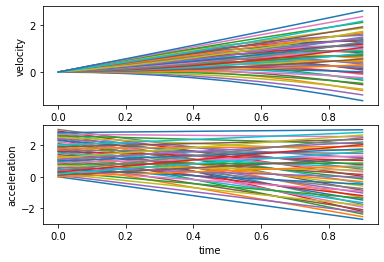

In [68]:
#configs = [(A0, AT, 100) for A0 in range(-1, 2) for AT in range(-1, 2)]
#curves = [gen_4deg_polynomial(A0, AT, VT) for A0, AT, VT in configs]

# Nominally, limits are in steps per millisecond
#min_j = -0.1
#max_j = 0.1

# Choosing accel limits to match velocity limits for NSAMP samples
max_a = 3 #max_v / NSAMP
min_a = -3 #min_v / NSAMP
print(f"min_a {min_a}, max_a {max_a}")

min_j = -0.5 #(min_a - max_a) / T
max_j = 0.5 #(max_a - min_a) / T
print(f"min_j {min_j}, max_j {max_j}")

# Max velocity happens when zero jerk at max limit of acceleration
max_v = 0.5*(0)*(TEND**2) + max_a*TEND
# Min velocity happens when max negative jerk starting at 0 accel
min_v = 0.5*min_j*(TEND**2) + (0)*TEND
print(f"min_v {min_v}, max_v {max_v}")

max_bytes = 512000
storage_type = 2 # int16_t
max_num_curves = max_bytes / (storage_type * NSAMP)
print(f"max {max_num_curves} allowed for storing {NSAMP} samples of {storage_type}-byte values in {max_bytes}B memory")
# ((num_a/2)+1) * num_a = max_num_curves
# 0.5*num_a**2 + num_a - max_num_curves = 0
# Hello, quadratic formula.
num_a0 = 31
num_a = num_a0*2+1 #math.floor(-1 + math.sqrt(1 - 4*0.5*(-max_num_curves)))
print(f"num_a: {num_a}, num_a0: {num_a0}")
configs = [(A0, AT) 
               for AT in np.linspace(min_a, max_a, num_a)
               for A0 in np.linspace(0, max_a, num_a0) 
          ]
# configs = [(A0, J) for A0 in np.arange(min_a-1, max_a+1, a_resolution) for J in [min_j, 0, max_j]]
curves = [gen_constant_jerk_polynomial(A0, AT) for A0, AT in configs]
jerks = [c.J for c in curves]
print(f"Generated {len(curves)} curves, {len(curves)*NSAMP*2 / 1024}KB")

plt.subplot(211)
plt.xlabel("time")
plt.ylabel("velocity")
plt.subplot(212)
plt.xlabel("time")
plt.ylabel("acceleration")

nshow = 50
print(f"Showing a sample of ~{nshow} curves:")
for i, c in enumerate(curves):
    if i % int(len(curves)/nshow) != 0:
        continue
    time = np.arange(0, 1.0, 0.1)
    adata = np.array([c.accFn(t) for t in time])
    vdata = np.array([c.velFn(t) for t in time])
    plt.subplot(211)
    plt.plot(time, vdata)
    plt.subplot(212)
    plt.plot(time, adata)
plt.show()


Total time in usec: 5970017
Curve(J=0.967741935483871, A0=0.0, T=1.0, AT=0.967741935483871, VT=0.4838709677419355, accFn=<function gen_constant_jerk_polynomial.<locals>.<lambda> at 0x7fac7d582820>, velFn=<function gen_constant_jerk_polynomial.<locals>.<lambda> at 0x7fac7d5828b0>)
Curve(J=-1.0, A0=1.0, T=1.0, AT=0.0, VT=0.5, accFn=<function gen_constant_jerk_polynomial.<locals>.<lambda> at 0x7fac7fae6160>, velFn=<function gen_constant_jerk_polynomial.<locals>.<lambda> at 0x7fac7fae61f0>)
Curve(J=0.0, A0=0.0, T=1.0, AT=0.0, VT=0.0, accFn=<function gen_constant_jerk_polynomial.<locals>.<lambda> at 0x7fac7faed5e0>, velFn=<function gen_constant_jerk_polynomial.<locals>.<lambda> at 0x7fac7faed670>)
Curve(J=-1.064516129032258, A0=0.0, T=1.0, AT=-1.064516129032258, VT=-0.532258064516129, accFn=<function gen_constant_jerk_polynomial.<locals>.<lambda> at 0x7fac75e55040>, velFn=<function gen_constant_jerk_polynomial.<locals>.<lambda> at 0x7fac75e550d0>)
Curve(J=-1.0, A0=1.0, T=1.0, AT=0.0, VT=0.5

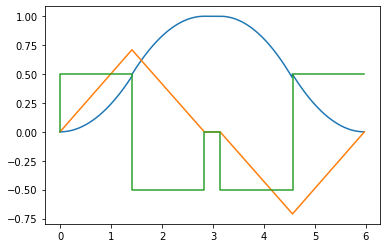

In [70]:
intent_set = [
(1271, 1, 0.0, 1414213),
(971, 1, 0.5000000000000001, 1414213),
(961, 1, 1.0000000000000002, 313165),
(620, 1, 1.0000000000000002, 1414213),
(971, -1, 0.5000000000000001, 1414213),
]
expected_t = [0,  1.41, 2.83, 3.14, 4.56, 5.97]
expected_j = [0, 0.5, -0.5, 0, -0.5, 0.5]
expected_a = [0, 0.71, 0, 0, -0.71, 0]
expected_vt = np.linspace(0, expected_t[-1], 20)

max_t = sum([i[3] for i in intent_set])
print("Total time in usec:", max_t)
t_step = 0.01
t_start = 0
vals = []
times = []
for (curve_id, scale, shift, t_amt) in intent_set:
    t_amt /= 1000000
    c = curves[curve_id]
    print(c)
    for t in np.arange(0, t_amt, t_step):
        curve_t = t / t_amt
        vals.append(c.velFn(curve_t)*scale + shift)
        times.append((t_start + t))
    t_start += t_amt
plt.plot(times, vals)
plt.plot(expected_t, expected_a)
plt.step(expected_t, expected_j)
plt.show()

In [102]:
def bracket(l):
    return str(l).replace("[", "{").replace("]", "}")  

data = np.array([[c.velFn(s) for s in np.linspace(0, c.T, NSAMP)] for c in curves])
v_bound_min = np.amin(data)
v_bound_max = np.amax(data)
vel_scale = int((2**15-1) / (max(abs(v_bound_min), abs(v_bound_max))))
print(f"v_bound_min={v_bound_min}, v_bound_max={v_bound_max} -> vel_scale={vel_scale}")

data = (data * vel_scale).astype(int)
assert np.amax(data) < 32767, f"Max exceeds bounds of 16-bit integer: got {np.amax(data)}"
assert np.amin(data) > -32768, f"Min exceeds bounds of 16-bit integer: got {np.amin(data)}"

def gen_curve_data(c): 
    pass
    #dmin = np.min(data)
    #dmax = np.max(data)
    #scale = 0 if dmax-dmin == 0 else (2**16-1) / (dmax-dmin)
    #shift = dmin
    # print(f"bounds=({dmin:0.2f},{dmax:0.2f}), scale={scale:0.2f}, shift={shift:0.2f}")
    #data = [ int(vel_scale*d) for d in data ]
    #assert np.max(data) < 32767, f"Max for curve {c} exceeds bounds of 16-bit integer: got {np.max(data)}"
    #
    #assert(np.min(data) > -32768)

def make_curves_c_file(curves):
    
    vel_data = []
    js = []
    a0s = []
    for i, c in enumerate(curves):
        js.append(c.J)
        a0s.append(c.A0)
        vel_data.append(bracket(data[i]))
    
    return (
        f"// THIS FILE IS AUTO GENERATED - DO NOT MODIFY\n" +
        f"// See curve_generator.ipynb for details\n" + 
        f"#include \"curves.h\"\n\n" +
        f"const int16_t CURVES_MAX_V = {int(max_v*256)}; //8-bit fixed point\n" +
        f"const int16_t CURVES_MIN_V = {int(min_v*256)}; //8-bit fixed point\n" +
        f"const int16_t VEL_SCALE = {int(vel_scale*256)}; //8-bit fixed point\n" +
        f"const int32_t CURVES_T_END_USEC = {int(TEND*1000000)};\n" +
        #f"const float CURVE_J[] = {bracket(js)};\n" + 
        #f"const float CURVE_A0[] = {bracket(a0s)};\n" + 
        "const uint16_t CURVES[][CURVE_SZ] = {\n" +
        f",\n  ".join(vel_data) +
        "\n};"
    )

with open("./curves.c", "w") as f:
    f.write(make_curves_c_file(curves))
print("wrote curves.c")

v_bound_min=-1.5, v_bound_max=3.0 -> vel_scale=10922
wrote curves.c
